# Cleanup Pipeline 4


*Purpose*
- generalize the **DocumentToBigramCounterTransformer** class to a **DocumentToNgramCounterTransformer** class. 

*Concerns*
- has same issues as Bigram class (stop words in Ngrams, no Ngram-only option)
- also noticed other transformations might not have worked, like expand_contractions (Ex. "havent_done"); why?
- potentially slower because of the for loop in `self.n_grams`

*Results*
- using the same dataset $(m=120k,n=50k)$ on the new **DocumentToNgramCounterTransformer** class set to the default (Bigram) produces the same exact results as the previous **DocumentToBigramCounterTransformer** class
- Bigrams (more precisely, datasets of unigrams and bigrams) achieve a plateau of about 80% accuracy using a baseline Logistic Regression model, with vocabulary sizes ranging from 30,000 to 150,000 terms, and take approximately 110 seconds to train and perform 5-fold CV with both Naive Bayes and LR models
- Trigrams (up-to-trigram datasets) perform similarly with a narrower plateau but a training time that is surprisingly twice as fast as bigrams, and the best accuracy is 80.08% with 100,000 terms
- Quadrigrams do not perform as well and stay slightly below the 80% threshold
- Vocabulary sizes do not appear to influence training time as expected, in fact higher vocabulary sizes for bigrams appear to perform faster than mid-size vocab sizes

---

In [1]:
import re
import os
import time
import json

import numpy as np
import pandas as pd

import urlextract
from html import unescape

from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import cleanup_module as Cmod

from scipy.sparse import csr_matrix
from collections import Counter

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split

---

### Hybrid approach

In [2]:
def expand_contractions(text, contractions_map):
    
    pattern = re.compile('({})'.format('|'.join(contractions_map.keys())), 
                        flags=re.IGNORECASE|re.DOTALL)
    
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions_map.get(match)\
                                if contractions_map.get(match)\
                                else contractions_map.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

def is_ascii(doc):
    try:
        doc.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [3]:
class DocumentToNgramCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, expand_contractions=True, lower_case=True, 
                 replace_usernames=True, unescape_html=True, 
                 replace_urls=True, replace_numbers=True, 
                 remove_junk=True, remove_punctuation=True, 
                 replace_emojis=True, replace_nonascii=True, 
                 remove_stopwords=True, lemmatization=True,
                 n_grams=2 # defaults to bigram
                ): 
        self.expand_contractions = expand_contractions
        self.lower_case = lower_case
        self.replace_usernames = replace_usernames
        self.unescape_html = unescape_html
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.remove_junk = remove_junk
        self.remove_punctuation = remove_punctuation
        self.replace_emojis = replace_emojis
        self.replace_nonascii = replace_nonascii
        self.remove_stopwords = remove_stopwords
        self.lemmatization = lemmatization
        self.n_grams = n_grams
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for doc in X:
            if self.lower_case:
                doc = doc.lower()
            if self.expand_contractions and contractions_map is not None:
                doc = expand_contractions(doc, contractions_map)
            if self.replace_usernames:
                doc = re.sub(r'^@([^\s]+)',' USERNAME ', doc)
            if self.unescape_html:
                doc = unescape(doc)
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(doc)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    doc = doc.replace(url, ' URL ')
            if self.replace_numbers:
                doc = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', ' NUMBER ', doc)
            if self.remove_junk:
                pattern = r'\¥|\â|\«|\»|\Ñ|\Ð|\¼|\½|\¾|\!|\?|\¿|\x82\
                            |\x83|\x84|\x85|\x86|\x87|\x88|\x89|\
                            |\x8a|\x8b|\x8c|\x8d|\x8e|\°|\µ|\´|\º|\¹|\³'
                doc = re.sub(pattern,'', doc)
            if self.remove_punctuation:
                doc = re.sub(r'\W+', ' ', doc, flags=re.M)
            if self.replace_emojis:
                doc = re.sub(r'[^\x00-\x7F]+', ' EMOJI ', doc)
            if self.replace_nonascii:
                if is_ascii(doc) == False:
                    doc = ' NONASCII '
            # tokenize
            tokens = doc.split()
            if self.remove_stopwords:
                stop_words = ['a','an','and','are','as','at','be','by','for','from',
                              'has','he','in','is','it','its','of','on','that','the',
                              'to','was','were','will','with']
                tokens = [t for t in tokens if t not in stop_words]
            if self.lemmatization and lemmatizer is not None:
                tokens = [lemmatizer.lemmatize(t) for t in tokens]
            if self.n_grams:
                for i in range(2, self.n_grams+1): # fix doubling of unigrams
                    grams = ngrams(word_tokenize(doc), i)
                    grams = ['_'.join(gram) for gram in grams]
                    tokens = [*tokens, *grams]
            # include counts
            tokens_counts = Counter(tokens)
            # append to list
            X_transformed.append(tokens_counts)
        return np.array(X_transformed)

In [4]:
with open("contractions_map.json") as f:
    contractions_map = json.load(f)

url_extractor = urlextract.URLExtract()
lemmatizer = WordNetLemmatizer()

In [5]:
corpus = ['You The love me', # added stopword to see if/how it gets throw out
          'You do not love me',
          'You really really love food']

In [6]:
wordvec = DocumentToNgramCounterTransformer(n_grams=3)
X_trans = wordvec.fit_transform(corpus)

In [7]:
X_trans

array([Counter({'you': 1, 'love': 1, 'me': 1, 'you_the': 1, 'the_love': 1, 'love_me': 1, 'you_the_love': 1, 'the_love_me': 1}),
       Counter({'you': 1, 'do': 1, 'not': 1, 'love': 1, 'me': 1, 'you_do': 1, 'do_not': 1, 'not_love': 1, 'love_me': 1, 'you_do_not': 1, 'do_not_love': 1, 'not_love_me': 1}),
       Counter({'really': 2, 'you': 1, 'love': 1, 'food': 1, 'you_really': 1, 'really_really': 1, 'really_love': 1, 'love_food': 1, 'you_really_really': 1, 'really_really_love': 1, 'really_love_food': 1})],
      dtype=object)

In [8]:
pipe = Pipeline([('counter', DocumentToNgramCounterTransformer(n_grams=3)),
                 ('bow', Cmod.WordCounterToVectorTransformer(vocabulary_size=20)),
                 ('tfidf', TfidfTransformer())])

In [9]:
pipe_counter = pipe['counter'].fit_transform(corpus)

In [10]:
pipe_bow = pipe['bow'].fit(pipe_counter)

In [11]:
pipe_bow.vocabulary_

{'you': 1,
 'love': 2,
 'me': 3,
 'love_me': 4,
 'really': 5,
 'you_the': 6,
 'the_love': 7,
 'you_the_love': 8,
 'the_love_me': 9,
 'do': 10,
 'not': 11,
 'you_do': 12,
 'do_not': 13,
 'not_love': 14,
 'you_do_not': 15,
 'do_not_love': 16,
 'not_love_me': 17,
 'food': 18,
 'you_really': 19,
 'really_really': 20}

In [12]:
bow = pipe_bow.transform(pipe_counter)

In [13]:
bow.toarray() # first col is "words missing from vocab"

array([[0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [5, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1]],
      dtype=int32)

In [14]:
 # IDF for the pipe_bow.vocabulary_
[np.around(x,3) for x in pipe['tfidf'].fit(bow).idf_[1:]]

[1.0,
 1.0,
 1.288,
 1.288,
 1.693,
 1.693,
 1.693,
 1.693,
 1.693,
 1.693,
 1.693,
 1.693,
 1.693,
 1.693,
 1.693,
 1.693,
 1.693,
 1.693,
 1.693,
 1.693]

In [15]:
tfidf = pipe['tfidf'].fit_transform(bow)

In [16]:
[np.around(x,4) for x in tfidf.toarray()]

[array([0.    , 0.2441, 0.2441, 0.3143, 0.3143, 0.    , 0.4133, 0.4133,
        0.4133, 0.4133, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    ]),
 array([0.    , 0.1881, 0.1881, 0.2423, 0.2423, 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.3186, 0.3186, 0.3186, 0.3186, 0.3186, 0.3186,
        0.3186, 0.3186, 0.    , 0.    , 0.    ]),
 array([0.8744, 0.1033, 0.1033, 0.    , 0.    , 0.3498, 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.1749, 0.1749, 0.1749])]

In [17]:
# entire pipeline produces same result but does't save IDF or vocab
end_res = pipe.fit_transform(corpus)
[np.around(x,4) for x in end_res.toarray()]

[array([0.    , 0.2441, 0.2441, 0.3143, 0.3143, 0.    , 0.4133, 0.4133,
        0.4133, 0.4133, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    ]),
 array([0.    , 0.1881, 0.1881, 0.2423, 0.2423, 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.3186, 0.3186, 0.3186, 0.3186, 0.3186, 0.3186,
        0.3186, 0.3186, 0.    , 0.    , 0.    ]),
 array([0.8744, 0.1033, 0.1033, 0.    , 0.    , 0.3498, 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.1749, 0.1749, 0.1749])]

### POC: sample 10% of the training data

About 120,000 instances.

In [18]:
# load minimally prepared X, y train subsets
raw_path = os.path.join("..","data","1_raw","sentiment140")
X_train = pd.read_csv(os.path.join(raw_path, "X_train.csv"))
y_train = pd.read_csv(os.path.join(raw_path, "y_train.csv"))

# sample 10%
X, X_rest, y, y_rest = train_test_split(X_train, y_train, test_size=0.9, random_state=42)

# create arrays
X_array = np.array(X.iloc[:, 2]).ravel()
y_array = y.iloc[:,0].ravel()

### Bigrams

Here I just confirm that the new Ngram class works just as the previous Bigram class.

In [19]:
# full pipe
pipe = Pipeline([('counter', DocumentToNgramCounterTransformer()), # should be the same as Bigram transformer
                 ('bow', Cmod.WordCounterToVectorTransformer(vocabulary_size=50000)),
                 ('tfidf', TfidfTransformer())])

In [20]:
start_time = time.time()

X_counter = pipe['counter'].fit_transform(X_array)

mins, secs = divmod(time.time() - start_time, 60)
print(f'Elapsed: {mins:0.0f} min {secs:0.0f} sec')

Elapsed: 1 min 41 sec


In [21]:
X_counter_fit = pipe['bow'].fit(X_counter)

In [22]:
for ix, tuple_ in enumerate(X_counter_fit.vocabulary_.items()):
    if ix < 10 or ix > X_counter_fit.vocabulary_size-10:
        print(tuple_)

('i', 1)
('USERNAME', 2)
('NUMBER', 3)
('my', 4)
('you', 5)
('not', 6)
('am', 7)
('have', 8)
('i_am', 9)
('me', 10)
('and_nearly', 49992)
('wishing_everyone', 49993)
('in_twitterland', 49994)
('in_december', 49995)
('mouthed', 49996)
('claw', 49997)
('ass_day', 49998)
('bagus', 49999)
('follow_gw', 50000)


In [23]:
X_bow = pipe['bow'].fit_transform(X_counter)
X_bow

<119747x50001 sparse matrix of type '<class 'numpy.intc'>'
	with 2232287 stored elements in Compressed Sparse Row format>

In [24]:
X_tfidf = pipe['tfidf'].fit_transform(X_bow)
X_tfidf

<119747x50001 sparse matrix of type '<class 'numpy.float64'>'
	with 2232287 stored elements in Compressed Sparse Row format>

#### Naive Bayes

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

NB_clf = MultinomialNB()

# BoW with bigrams
score = cross_val_score(NB_clf, X_bow, y_array, cv=10, verbose=1, scoring='accuracy')
print(f'Accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy: 0.7890 (+/- 0.0022)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.5s finished


In [26]:
# Tfidf with bigrams
score = cross_val_score(NB_clf, X_tfidf, y_array, cv=10, verbose=1, scoring='accuracy')
print(f'Accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy: 0.7908 (+/- 0.0024)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.7s finished


#### Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(solver="liblinear", random_state=42)

# BoW with bigrams
score = cross_val_score(log_clf, X_bow, y_array, cv=10, verbose=1, scoring='accuracy', n_jobs=-1)
print(f'Accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:   18.4s remaining:   12.2s


Accuracy: 0.7895 (+/- 0.0021)


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   28.1s finished


In [28]:
# Tfidf with bigrams
score = cross_val_score(log_clf, X_tfidf, y_array, cv=10, verbose=1, scoring='accuracy', n_jobs=-1)
print(f'Accuracy: {score.mean():0.4f} (+/- {np.std(score):0.4f})')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of  10 | elapsed:    3.7s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.2s finished


Accuracy: 0.8019 (+/- 0.0024)


### N-grams

In [29]:
def gridsearch_ngrams(X_array, y_array, n_grams, vocab_sizes):
    T1 = time.time()
    fit_times, NB_means, NB_stds, LR_means, LR_stds = [], [], [], [], []

    for vocab_size in vocab_sizes:
        start = time.time()
        pipe = Pipeline([('counter', DocumentToNgramCounterTransformer(n_grams=n_grams)),
                         ('bow', Cmod.WordCounterToVectorTransformer(vocabulary_size=vocab_size)),
                         ('tfidf', TfidfTransformer())])
        
        # fit_transform
        X_transformed = pipe.fit_transform(X_array)
        fit_times.append(round(time.time() - start, 1))
        
        # instantiate models
        NB_clf = MultinomialNB()
        log_clf = LogisticRegression(solver="liblinear", random_state=42)
        
        # NB
        scores = cross_val_score(NB_clf, X_transformed, y_array, cv=5, 
                                 verbose=0, scoring='accuracy', n_jobs=-1)
        NB_means.append(round(scores.mean(), 4))
        NB_stds.append(round(np.std(scores), 4))
        
        # LR
        scores = cross_val_score(log_clf, X_transformed, y_array, cv=5, 
                                verbose=0, scoring='accuracy', n_jobs=-1)
        LR_means.append(round(scores.mean(), 4))
        LR_stds.append(round(np.std(scores), 4))

    df = pd.DataFrame({"ngram":n_grams,
                       "vocab_size":vocab_sizes,
                       "fit_time":fit_times,
                       "NB_mean":NB_means,
                       "NB_std":NB_stds,
                       "LR_mean":LR_means,
                       "LR_std":LR_stds
                      })
    
    mins, secs = divmod(time.time() - T1, 60)
    print(f'Elapsed: {mins:0.0f} m {secs:0.0f} s')
    
    return df

In [30]:
vocab_sizes = list(range(50, 5000, 500)) \
            + list(range(5000, 50000, 5000)) \
            + list(range(50000, 500000, 50000)) \
            + list(range(500000, 5050000, 500000))

In [31]:
bigram_df = gridsearch_ngrams(X_array, y_array, 2, vocab_sizes)

Elapsed: 43 m 27 s


In [32]:
trigram_df = gridsearch_ngrams(X_array, y_array, 3, vocab_sizes)

Elapsed: 38 m 59 s


In [33]:
quadrigram_df = gridsearch_ngrams(X_array, y_array, 4, vocab_sizes)

Elapsed: 48 m 8 s


In [34]:
master_df = pd.concat([bigram_df, trigram_df, quadrigram_df])
master_df.index = range(len(master_df))
master_df

,ngram,vocab_size,fit_time,NB_mean,NB_std,LR_mean,LR_std
0,2,50,88.4,0.6465,0.0019,0.6541,0.0022
1,2,550,42.3,0.7324,0.0021,0.7478,0.0017
2,2,1050,41.8,0.7470,0.0011,0.7624,0.0014
3,2,1550,43.3,0.7548,0.0010,0.7711,0.0014
4,2,2050,42.8,0.7603,0.0008,0.7773,0.0006
5,2,2550,42.1,0.7659,0.0018,0.7820,0.0010
6,2,3050,42.9,0.7683,0.0021,0.7846,0.0013
7,2,3550,42.9,0.7711,0.0015,0.7866,0.0006
8,2,4050,42.4,0.7722,0.0021,0.7881,0.0014
9,2,4550,54.2,0.7742,0.0021,0.7893,0.0015


In [36]:
save_dir = os.path.join("..","data","4_models","sentiment140")
master_df.to_csv(os.path.join(save_dir, "Ngram_Tfidf_baseline_accuracies.csv"), index=False)

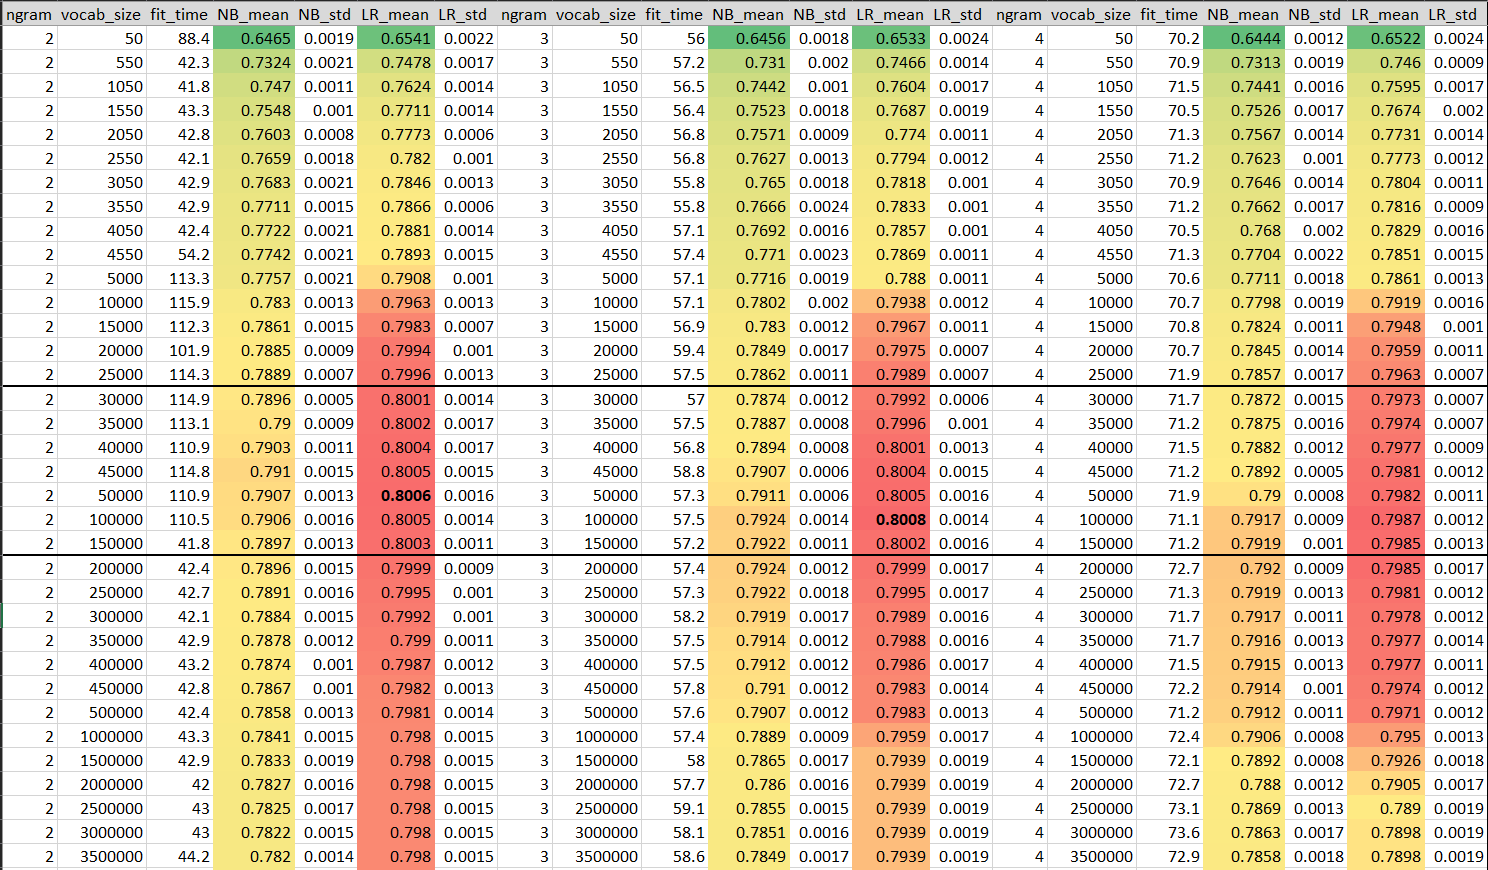

In [37]:
from IPython.display import Image
Image(os.path.join(save_dir, "Ngram_Tfidf_baseline_accuracies.PNG"))

A quick Excel analysis with conditional formatting shows how Logistic Regression achieves better accuracies in general, how bigrams have a flatter and broader peak of accuracies with many values over 80%, but trigrams with a vocabulary size of 100,000 terms achieves the best accuracy and training speed. Quadrigrams do not seem to perform as well and so we suspect there's no need to increase N and test quintigrams.

---